In [1]:
import pyspark
from pyspark.sql import SparkSession

In [2]:
import pyspark
from pyspark.sql.functions import col
from pyspark.sql.functions import min, max
from pyspark.sql.functions import *
from pyspark.sql.functions import mean
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import seaborn as sns
from pyspark import pandas

/home/oem/anaconda3/lib/python3.9/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [3]:
spark = SparkSession.builder.appName("Location Ping Data Cleaning").getOrCreate()

23/06/27 21:25:45 WARN Utils: Your hostname, oem-VivoBook-ASUSLaptop-X571GT-F571GT resolves to a loopback address: 127.0.1.1; using 192.168.1.80 instead (on interface wlp4s0)
23/06/27 21:25:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/27 21:25:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/06/27 21:25:46 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
df = spark.read.parquet("/home/oem/Documents/Tamoco_data_engineering_test/sample_data.snappy.parquet")

In [5]:
df.show()

23/06/27 21:26:33 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+---------------+----------+----------+--------------+--------------------+-------------------+-----------+--------------------+--------------+---------+-----------------+-----------+------------+-------+---------+----------+--------+--------+---------------+---------+------------+-------------+--------------+-------+------+---------------+-------------------+------------------+------------------+------+
|            FILENAME|FILE_ROW_NUMBER|ACCOUNT_ID|APP_ID_IOS|APP_ID_ANDROID|        CREATED_DATE|         EVENT_DATE|EVENT_EPOCH|           DEVICE_ID|   DEVICE_TYPE|DEVICE_OS|DEVICE_OS_VERSION|DEVICE_MAKE|DEVICE_MODEL|CARRIER| LATITUDE| LONGITUDE|ACCURACY|ALTITUDE|             IP|GEOHASH_6|IS_BIDSTREAM|IS_GB_ALLOWED|CONSENT_STATUS|COUNTRY|REGION|       TIMEZONE|         LOCAL_TIME|IS_GEOHASH_MATCHED|IAB_CONSENT_STATUS|APP_ID|
+--------------------+---------------+----------+----------+--------------+--------------------+-------------------+-----------+--------------

In [6]:
# Drop the unnecessary columns
df = df.drop("ALTITUDE", "IAB_CONSENT_STATUS")

In [7]:
# Remove the duplicated pings
df1 = df.dropDuplicates()

In [12]:
# Find the location and time range of data
location = df1.select("latitude", "longitude")
time_range = df1.select(
      col("CREATED_DATE"),
      col("LOCAL_TIME"),
      datediff(col("CREATED_DATE"),col("LOCAL_TIME")).alias("rang_of_date")
    ).show()

+--------------------+-------------------+------------+
|        CREATED_DATE|         LOCAL_TIME|rang_of_date|
+--------------------+-------------------+------------+
|2021-11-07 04:54:...|2021-11-06 21:45:57|           1|
|2021-11-07 04:54:...|2021-11-06 22:22:09|           1|
|2021-11-07 04:54:...|2021-11-06 04:09:59|           1|
|2021-11-07 04:54:...|2021-11-06 19:45:05|           1|
|2021-11-07 04:54:...|2021-11-06 02:42:30|           1|
|2021-11-07 04:54:...|2021-11-06 19:09:13|           1|
|2021-11-07 04:54:...|2021-11-06 21:37:44|           1|
|2021-11-07 04:54:...|2021-11-06 20:55:46|           1|
|2021-11-07 04:54:...|2021-11-06 05:02:41|           1|
|2021-11-07 04:54:...|2021-11-06 03:49:31|           1|
|2021-11-07 04:54:...|2021-11-06 07:22:14|           1|
|2021-11-07 04:54:...|2021-11-06 02:53:29|           1|
|2021-11-07 04:54:...|2021-11-06 04:09:46|           1|
|2021-11-07 04:54:...|2021-11-06 07:55:41|           1|
|2021-11-07 04:54:...|2021-11-06 18:47:19|      

In [13]:
# Calculate the average number of pings per device
pings_per_device = df1.groupBy(col("device_id")).count()
average_ping_per_device = pings_per_device.select(mean("count").alias("average_ping_per_device")).show(truncate=False)

+-----------------------+
|average_ping_per_device|
+-----------------------+
|6.349926267395318      |
+-----------------------+



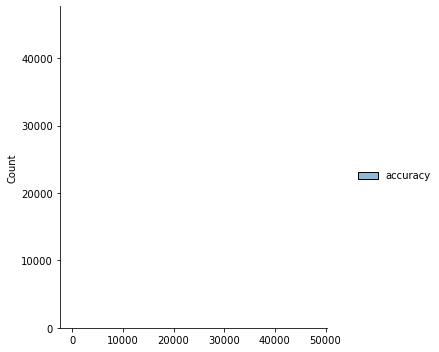

In [14]:
# Plot the distribution of accuracy of android devices

sample_df = df1.select(['accuracy'])

pandas_df = sample_df.toPandas()

sns.displot(pandas_df)

In [15]:
# Find the hour in which devices sent the most pings
hour_with_most_ping = df1.select(col('device_id'),col('LATITUDE'),col('LONGITUDE'),col('EVENT_DATE')).groupBy("device_id","LATITUDE","LONGITUDE","EVENT_DATE").count().sort("count",ascending=False).withColumnRenamed("count","ping").show()


+--------------------+---------+----------+-------------------+----+
|           device_id| LATITUDE| LONGITUDE|         EVENT_DATE|ping|
+--------------------+---------+----------+-------------------+----+
|68c8b8d2-b219-4d7...| 41.35127|-87.950295|2021-11-07 03:14:26|   4|
|cc6050f6-9e5e-41f...|41.880201|-87.750931|2021-11-07 00:19:58|   4|
|abeaa9f9-a555-4c2...|41.875292|-87.682192|2021-11-07 02:15:56|   4|
|f58d7359-ef07-4c2...|42.072072|-88.257159|2021-11-07 01:59:58|   4|
|73db740d-feb1-47d...|  41.5368|-87.791021|2021-11-06 07:49:25|   3|
|ca7569e9-1647-46e...|41.825904|-87.668254|2021-11-06 08:39:27|   3|
|53873e04-b9d8-400...|  41.7966|-88.105805|2021-11-07 02:24:34|   3|
|6fc594a1-c675-4bb...|41.529032|-87.357088|2021-11-07 02:49:46|   3|
|f62d4c52-c99a-451...|41.867396|-88.015575|2021-11-06 07:20:55|   3|
|7ecfa31e-256e-498...|41.945945|-87.694743|2021-11-07 03:14:08|   3|
|5db7aded-cdcb-43b...|41.980053|-87.827747|2021-11-07 01:43:41|   3|
|9004aa95-e620-465...|42.129189|-8

In [16]:
#Find the number of redundant pings in the data set. If a device sends more than 2 pings with a rate greater than 1 ping/hour from the same location (the same latitude/longitude), pings exceptthe first and last ones are redundant.
def find_redundant_pings(hour_with_most_ping):
    grouped_df = hour_with_most_ping.groupby("device_id")
    redundant_pings = []
    for device_id, ping in grouped_df:
        if len(ping) > 2:
            for i in range(1, len(ping) - 1):
                if ping[i - 1]["EVENT_DATE"] - ping[i]["EVENT_DATE"] < 3600 & hour_with_most_ping.select("LATITUDE") == hour_with_most_ping.select("LONGITUDE"):
                    redundant_pings.append(ping[i])
    redundant_pings_df = grouped_df.to_frame().drop(["count", "size"], axis=1)
    return redundant_pings_df
